### Methods

We preprocessed the data, converting categorical variables (province, age group, and sex) into integer indices. The prevalence of Autism Spectrum Disorder (ASD), originally given in rho_adj, was transformed into the logit scale (logit_rho_adj). Prior beliefs were set with a mean of logit(0.02), reflecting an assumed prevalence of 2%, and a standard deviation of 0.06, based on Deitz's simulation interval. The prior for the sex effect, b_sex, in the hierarchical model is set to be a normal distribution with a mean of np.log(4) and a standard deviation of 1. This implies that before seeing the data, we believe that the odds of ASD prevalence in males is four times the odds in females. The standard deviation of 1 for this prior indicates a moderate level of uncertainty around this 4:1 odds ratio. The population size for each province, age group, and sex combination was transformed into a logarithmic scale (log_population) to serve as an offset in the model.

The statistical analysis was performed using a Bayesian hierarchical model with the Python library PyMC3. The model included hyperpriors (mu_a, sigma_a), province random effects (a), fixed effects for age group (b_age) and sex (b_sex), and model error (eps). The expected prevalence of ASD on the logit scale was modeled as a linear function of these terms. The model was estimated using the No-U-Turn Sampler (NUTS), a form of Hamiltonian Monte Carlo sampling. We used 16 cores to run 16 chains in parallel, each drawing 10,000 samples after a tuning phase of 10,000 iterations. The acceptance target for the sampling process was set at 0.9.

#### Analysis

Model parameters were estimated using the Hamiltonian Monte Carlo sampling method implemented in PyMC3. We generated samples from the posterior distribution of the parameters by specifying the model's structure and priors, and providing the observed data. The NUTS sampler was used to explore the parameter space efficiently, which is especially important given the high-dimensional nature of our model.

Model convergence and adequate mixing were assessed by visual inspection of trace plots and autocorrelation plots generated by the pm.traceplot() and pm.autocorrplot() functions, respectively. The pm.summary() function was used to provide summary statistics for each parameter, including the mean, standard deviation, and 94% Highest Posterior Density Interval (HPDI).

To estimate the prevalence for each group and its credible interval, we generated samples from the posterior predictive distribution using the pm.sample_posterior_predictive() function. This function generates new data by drawing parameter values from the posterior distribution and using them to simulate observations. The resulting samples represent our updated beliefs about the prevalence of ASD given the observed data and our model.

<b>Table</b>: Technical Details of the Bayesian Model

| Variable      | Description                                                                                   |
|:-------------|:--------------------------------------------------------------------------------------------- |
| mu_a, sigma_a | Hyperpriors, representing our prior beliefs about the province-level random effects          |
| a             | Province random effects, allowing for variation in ASD prevalence across provinces            |
| b_age, b_sex  | Fixed effects, representing the influence of age group and sex on ASD prevalence              |
| eps           | Model error, capturing unexplained variation in the data                                      |
| rho_est_logit | Expected ASD prevalence on the logit scale, computed as a linear function of the above terms  |
| NUTS          | No-U-Turn Sampler, the Hamiltonian Monte Carlo method used to estimate the model              |
| trace         | The samples drawn from the posterior distribution of the model's parameters                   |
| post_pred     | Samples drawn from the posterior predictive distribution, used to estimate ASD prevalence and credible intervals |


#### Step 1:  Import required libraries

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from sklearn.preprocessing import LabelEncoder
import arviz as az
import multiprocessing
from scipy.special import logit
from scipy.special import expit

In [2]:
data2=pd.read_csv('ASD Dataset.csv')

In [3]:
# Define bins and labels
bins = [18, 20, 25, 30,35,40,45,50,55,60,65,70,75,80,85, np.inf]  # change these values according to your needs
labels = ['18-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']

# Create a new column 'age_group' based on 'age' column
data2['age_group'] = pd.cut(data2['age'], bins=bins, labels=labels, right=False)

In [4]:
prov_age_sex=data2[['province','age_group','sex','population','gamma_adj']].groupby(['province', 'age_group', 'sex']).sum().reset_index()
prov_age_sex['rho_adj']=prov_age_sex['gamma_adj']/prov_age_sex['population']

prov_age_sex.to_csv('ASD by Province, Age, and Sex.csv', index=False)

In [5]:
# Convert categorical variables to integer indices
prov_age_sex['province'] = prov_age_sex['province'].astype('category')
prov_age_sex['province_cat'] = prov_age_sex['province'].cat.codes
n_provinces = len(prov_age_sex['province'].cat.categories)

prov_age_sex['age_group'] = prov_age_sex['age_group'].astype('category')
prov_age_sex['age_group_cat'] = prov_age_sex['age_group'].cat.codes
n_age_groups = len(prov_age_sex['age_group'].cat.categories)

prov_age_sex['sex'] = prov_age_sex['sex'].astype('category')
prov_age_sex['sex_cat'] = prov_age_sex['sex'].cat.codes

# Transform rho_adj to logit scale
prov_age_sex['logit_rho_adj'] = logit(prov_age_sex['rho_adj'])

# Prior beliefs
prior_mean = logit(0.02)  # Logit of 2%
prior_std_dev = 0.06  # This is an assumption based on Deitz simulation interval

# Take the log of the population size that will be used as an offset
prov_age_sex['log_population'] = np.log(prov_age_sex['population'])

In [6]:
# Define the model
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=prior_mean, sigma=prior_std_dev)
    sigma_a = pm.HalfCauchy('sigma_a', beta=1)
    
    # Province random effect
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_provinces)
    
    # Fixed effects
    b_age = pm.Normal('b_age', mu=0., sigma=1, shape=n_age_groups)
    b_sex = pm.Normal('b_sex', mu=np.log(4), sigma=1)

    # Expected value on logit scale, with population size as an offset
    rho_est_logit = a[prov_age_sex['province_cat']] + b_age[prov_age_sex['age_group_cat']] + b_sex*prov_age_sex['sex_cat'] + prov_age_sex['log_population']    
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)

    # Likelihood
    y_like = pm.Normal('y_like', mu=rho_est_logit, sigma=eps, observed=prov_age_sex['logit_rho_adj'])


Below, we are performing a tuning phase (burn-in) of 10,000 samples. After this, we draw 10,000 samples from the posterior distribution.

<b>NOTE</b>: I did not apply thinning as Deitz et al. did for their analysis. From, my understanding, thinning is sometimes used in Markov Chain Monte Carlo (MCMC) methods to reduce autocorrelation in the samples. However, it's not always necessary and can lead to discarding potentially useful samples.

In [7]:
n_cores = 16 #16 cores

# 'with' context manager is used with the model instance to perform operations within the context of this model
with hierarchical_model:
    # The 'pm.sample' function is used to draw samples from the posterior distribution of the model. 
    # 'draws=10000' is the number of samples drawn after tuning.
    # 'tune=10000' refers to the number of iterations used for tuning, i.e., the number of burn-in samples that are not included in the final trace.
    # 'target_accept=0.9' is the target acceptance probability for the Metropolis-Hastings or Hamiltonian Monte Carlo sampling methods.
    # 'init="auto"' is the initialization method used to start the sampling. Here 'jitter+adapt_diag' is being used.
    # 'cores=n_cores' is the number of chains to be sampled in parallel. Here, n_cores is the maximum number of available CPU cores.
    trace = pm.sample(draws=10000, tune=10000, init="auto",  chains= 16, cores=n_cores, step=[pm.NUTS(target_accept=0.9,max_treedepth=15)])

    # 'pm.sample_posterior_predictive' generates samples from the posterior predictive distribution, given the sampled trace.
    # 'var_names=["rho_adj_est"]' specifies that we only want to generate samples for the "rho_adj_est" variable.
    post_pred = pm.sample_posterior_predictive(trace, var_names=["y_like"])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [mu_a, sigma_a, a, b_age, b_sex, eps]


Sampling 16 chains for 10_000 tune and 10_000 draw iterations (160_000 + 160_000 draws total) took 390 seconds.
Sampling: [y_like]


In [15]:
df=pm.summary(trace)
df.to_csv('trace_summary_Normal.csv')

In [16]:
post_pred_data = post_pred["posterior_predictive"]["y_like"].values

# Reshape the data to merge the chains and samples
post_pred_data_reshaped = post_pred_data.reshape(-1, post_pred_data.shape[-1])

# Compute the mean prevalence estimate for each data point
mean_prevalence = post_pred_data_reshaped.mean(axis=0)

# Compute the 95% HPDI for each data point
hpd_interval = az.hdi(post_pred_data_reshaped, hdi_prob=0.95)

# Create a DataFrame with the results
prevalence_df = pd.DataFrame({
    "Estimated Prevalence": mean_prevalence,
    "Lower 95% HPDI": hpd_interval[:, 0],
    "Upper 95% HPDI": hpd_interval[:, 1],
})

# # Convert logit_rho_adj back to linear scale (rho_adj)
prevalence_df["Estimated Prevalence"] = expit(prevalence_df["Estimated Prevalence"])
prevalence_df["Lower 95% HPDI"] = expit(prevalence_df["Lower 95% HPDI"])
prevalence_df["Upper 95% HPDI"] = expit(prevalence_df["Upper 95% HPDI"])

C:\Users\Admin\AppData\Local\Temp\ipykernel_6780\2542066210.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = az.hdi(post_pred_data_reshaped, hdi_prob=0.95)


In [18]:
df=pd.concat([prov_age_sex, prevalence_df], axis=1)
df['asd_cases']=df['Estimated Prevalence']*df['population']
df['asd_LCL']=df['Lower 95% HPDI']*df['population']
df['asd_UCL']=df['Upper 95% HPDI']*df['population']

HPDI stands for Highest Posterior Density Interval. It is a credible interval (or a type of interval estimate) that gives us a range of values within which an unknown parameter (like the mean or variance) lies with a certain degree of belief (usually 95% or 99%).

In Bayesian statistics, the HPDI is a way of summarizing the posterior distribution of a parameter. For a 95% HPDI, you can say "Given the observed data and our prior beliefs, there's a 95% probability that the true value of the parameter is within this interval."

array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b_age'}>,
        <Axes: title={'center': 'b_age'}>],
       [<Axes: title={'center': 'b_sex'}>,
        <Axes: title={'center': 'b_sex'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

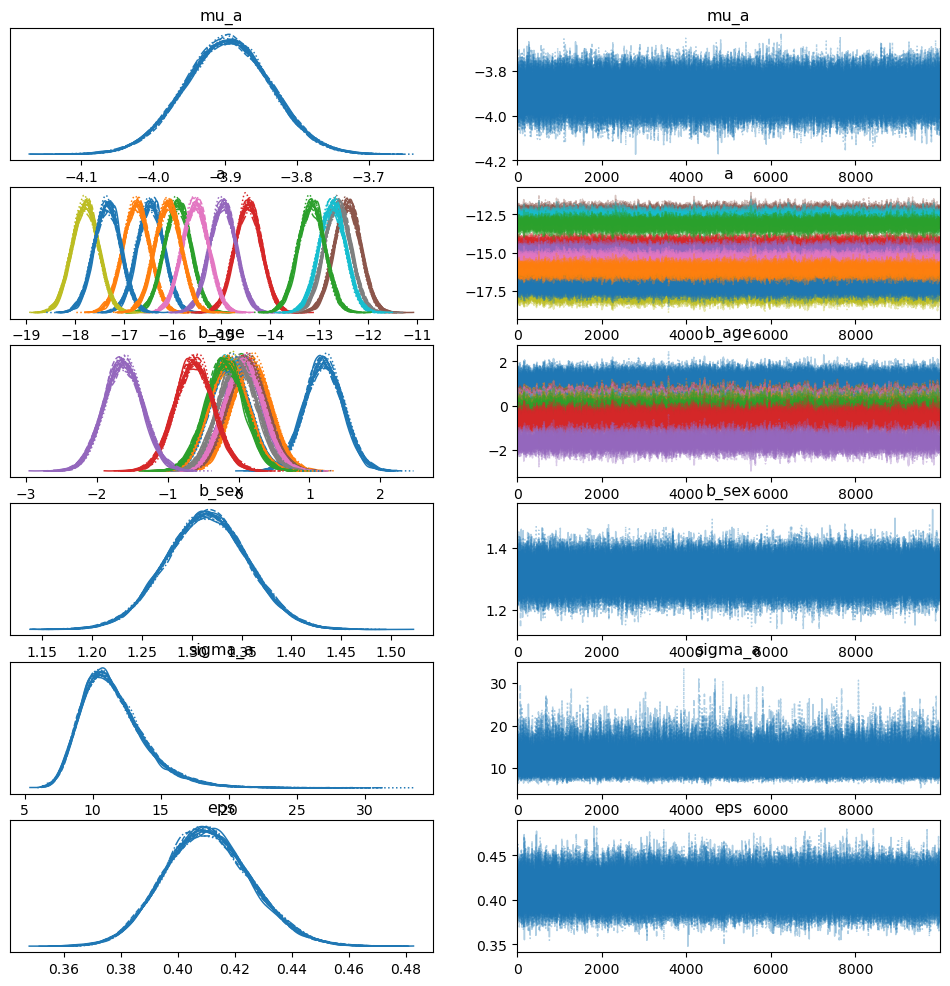

In [19]:
# assuming 'trace' is the result of an MCMC run
az.plot_trace(trace)

C:\Users\Admin\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (512) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'mu_a\n0'}>,
        <Axes: title={'center': 'mu_a\n1'}>,
        <Axes: title={'center': 'mu_a\n2'}>,
        <Axes: title={'center': 'mu_a\n3'}>],
       [<Axes: title={'center': 'mu_a\n4'}>,
        <Axes: title={'center': 'mu_a\n5'}>,
        <Axes: title={'center': 'mu_a\n6'}>,
        <Axes: title={'center': 'mu_a\n7'}>],
       [<Axes: title={'center': 'mu_a\n8'}>,
        <Axes: title={'center': 'mu_a\n9'}>,
        <Axes: title={'center': 'mu_a\n10'}>,
        <Axes: title={'center': 'mu_a\n11'}>],
       [<Axes: title={'center': 'mu_a\n12'}>,
        <Axes: title={'center': 'mu_a\n13'}>,
        <Axes: title={'center': 'mu_a\n14'}>,
        <Axes: title={'center': 'mu_a\n15'}>],
       [<Axes: title={'center': 'a\n0, 0'}>,
        <Axes: title={'center': 'a\n0, 1'}>,
        <Axes: title={'center': 'a\n0, 2'}>,
        <Axes: title={'center': 'a\n0, 3'}>],
       [<Axes: title={'center': 'a\n0, 4'}>,
        <Axes: title={'center': 'a\n0, 5'}>,

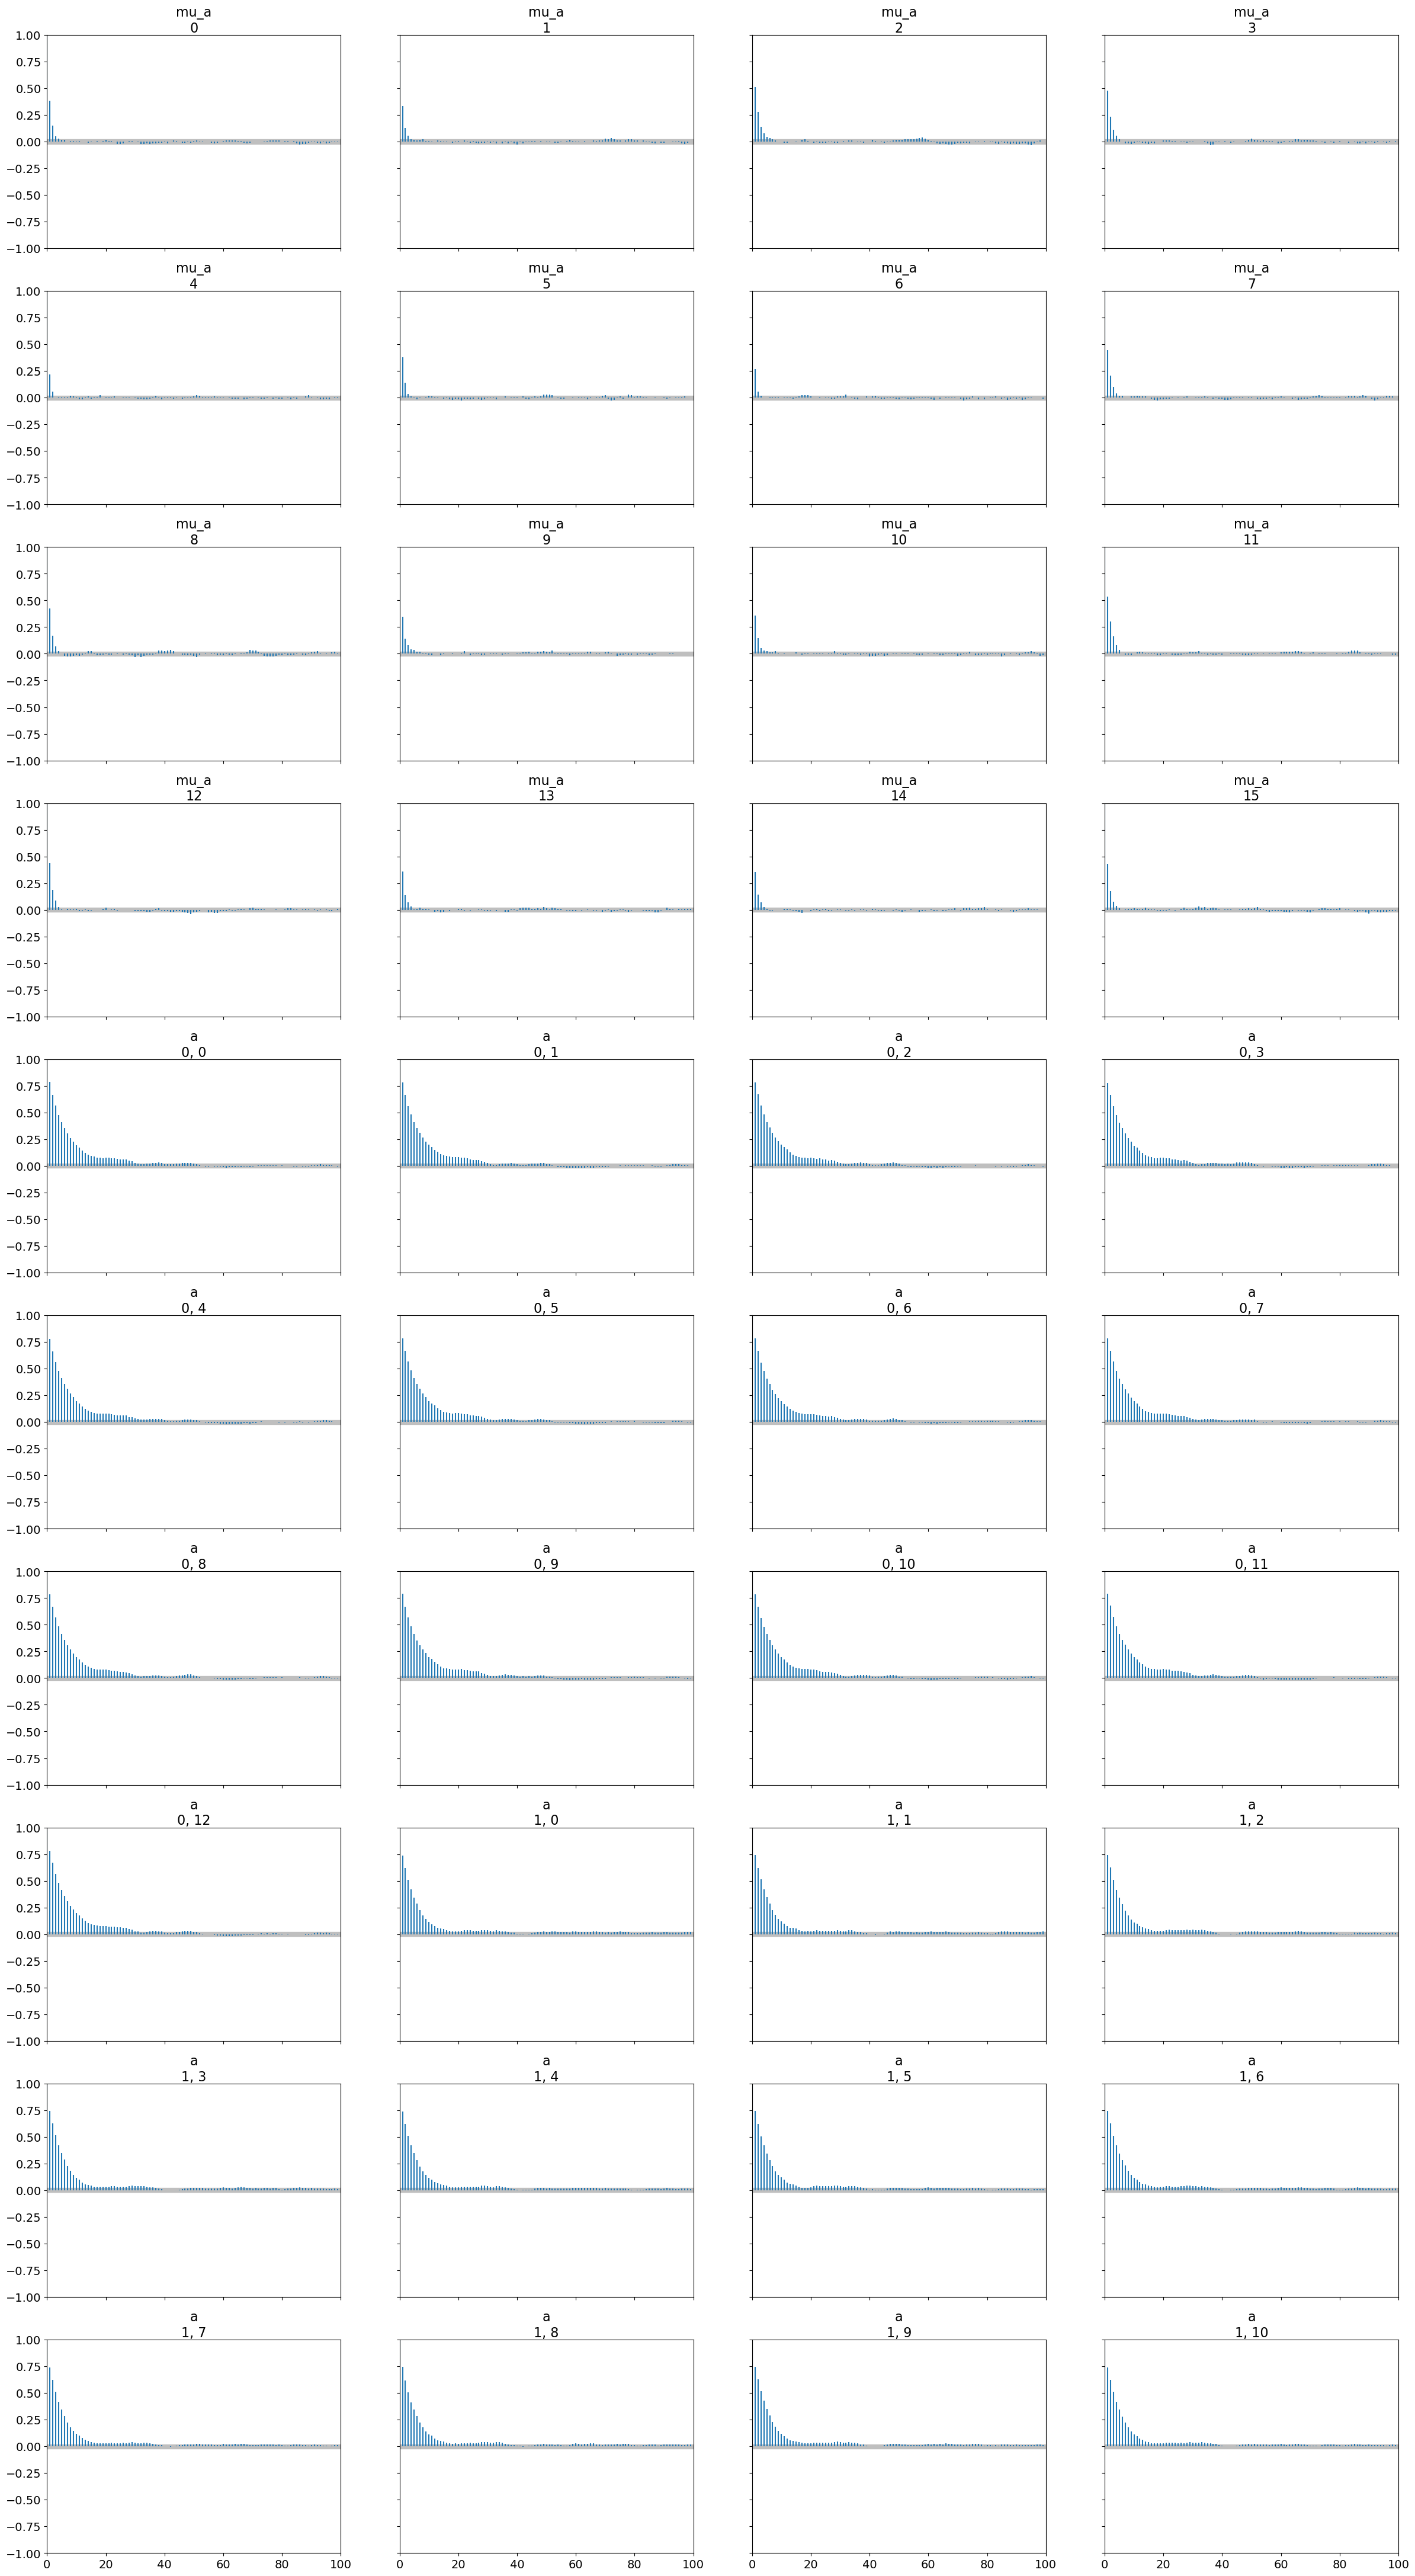

In [21]:
# assuming 'trace' is the result of an MCMC run
az.plot_autocorr(trace)

Sampling: [y_like]


<Axes: xlabel='y_like / y_like'>

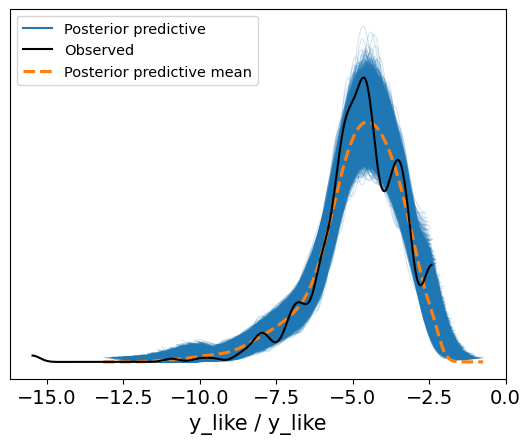

In [22]:
posterior = pm.sample_posterior_predictive(trace, model=hierarchical_model, return_inferencedata=True)
az.plot_ppc(posterior)